# Домашнее задание №6

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW6 <Фамилия Имя>**

soft deadline: 23.06.2020T23:59:00+0300

hard deadline: 30.06.2020T23:59:00+0300

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/MyDrive/Corel-10k/
# %ls

# Поиск изображений по содержанию (30 (+20) баллов)

Вам предстоит построить систему, которая позволит выполнить поиск изображений по содержанию в базе Corel-10k, которая приложена к домашнему заданию. База состоит из 100 классов изображений по 100 изображений в каждом классе. Имя каждого изображения в базе состоит из **X.JPEG**, где X - число от 1 до 10000. Изображения из одного класса лежат подряд в промежутке 1-100, 101-200, и тд. В файле **test.dat** лежит список картинок, которые не должны участвовать в построении поисковой базы, но по которым надо будет сделать 1000 поисковых запросов. Ограничение по памяти -- 2Гб.

1. По изображениям не попавшим в **test.dat** посчитайте дескриптор с помощью алгоритма GIST.
   
2. Разбейте дескрипторы всех изображений на 100 кластеров с помощью K-Means.

3. Для каждого кластера постройте функцию хэширования (LSH), с помощью которой закодируйте каждое изображение в тренировочной выборке.

5. Релизуйте функцию `retrieve` продемонстрируйте работу `retrieve` на 5-ти случайных изображениях из **test.dat**. Замерьте время исполнения поискового запроса. Сделайте возможность вызвать `retrieve` без построения индекса, то есть приложите в решение индексированную базу, если только время построения индекса не укладывается в 1 минуту.  

5. Сделайте 1000 запросов изображениями из файла **test.dat**.  Замерьте среднее время исполнения поискового запроса в colab ноутбуке.

    
6. Для каждого запроса нужно оценить AP@k, где k=10 и посчитать среднее значение этой величины по всем запросам (MAP). Формулу берем из этой презентации: https://web.stanford.edu/class/cs276/handouts/EvaluationNew-handout-1-per.pdf

Так же за это задание можно получить еще до 20-ти дополнительных баллов. 

1. Вы можете сделать быстрый поиск. Если качество вашего поиска окажется выше, чем медиана качества по всем поисковым движкам, то вы принимаете участие в 
борьбе за 10 призовых баллов. Первое место получает 10 баллов, второе 9, третье 8 и т.д. 

2. Вы можете сделать хороший поиск. Если ваш поиск окажется быстрее, чем медиана среднего времени работы других участников, то вы принимаете участие в борьбе за точный поиск. Распределение баллов здесь будет такое же как и в конкурсе на скорость. 

Для достижения лучших результатов вам придется регулировать несколько параметров алгоритма:
- Дескриптор. Можете взять что угодно вместо GIST
- Количество кластеров k-means
- Длину кода LSH
- etc 

Принципиально нельзя использовать готовые поисковые движки (annoy, faiss, etc, ..). И помните о том, что время поиска – очень важный параметр.
В случае использования нейросети инференс картинки производите без GPU ускорителя. Для обучения использовать GPU можно. Безусловно **не используйте изобржения из test.dat для обучения сети или построения поисковой базы**. 



---



Для итогового отчета посторойте таблицу в которой будет указано имя метода, значение MAP для этого метода, среднее время работы функции `revtrive` оцененное через утилиту `timeit` внутри GoogleCollab. (Базу вы можете построить на персональном копьютере.)

In [1]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy.lib import stride_tricks
from joblib import delayed, Parallel
from dataset import MyDataset
from lsh import LshCode
from utils import *
from gist import Gist
import pickle

In [2]:
# Extract train imgs

base_path = "Corel-10k"
img_paths = os.listdir(f"{base_path}/Images")

imgs_train = []
imgs_test = []

with open(f"{base_path}/test.dat", "r") as test:
  for test_img in test.readlines():
    imgs_test.append(test_img.strip())

for img in img_paths:
  if img  not in imgs_test:
    imgs_train.append("Corel-10k/Images/" + img)
    
imgs_test = [f"Corel-10k/Images/" + img for img in imgs_test]

train_ids = np.array([int(os.path.basename(img)[:-4]) for img in imgs_train])
test_ids = np.array([int(os.path.basename(img)[:-4]) for img in imgs_test])

train_ds = MyDataset(imgs_train)
test_ds = MyDataset(imgs_test)
print(len(train_ds), len(test_ds))

9000 1000


18


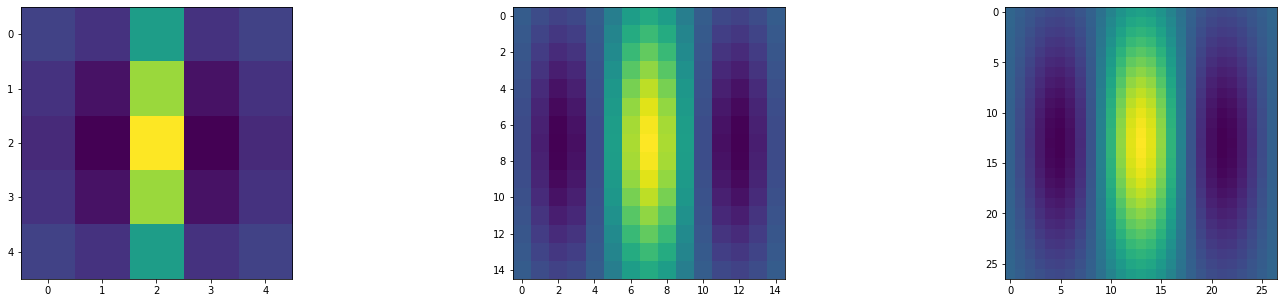

In [3]:
# Get array of filters
scale_bins = 3
phi_bins = 6
filters = gabour_bank(size=11, phi_bins=phi_bins, scale_bins=scale_bins, max_scale=18, min_scale=3, sigma_scale=0.5)
print(len(filters))
plt.figure(figsize=(25, 5))
for i, flt in enumerate(filters[:scale_bins]):
    plt.subplot(1, scale_bins, i + 1)
    plt.imshow(flt)

In [4]:
gist = Gist(filters, phi_bins=phi_bins, scale_bins=scale_bins, window_size=4)

get_emb = delayed(gist.get_gist_descriptor)

if os.path.exists("train_embeddings.pkl"):
    with open("train_embeddings.pkl", "rb") as tr_emb:
        train_embeddings = pickle.load(tr_emb)
else:
    train_embeddings = np.array(Parallel(n_jobs=8)(get_emb(img) for img in train_ds))
    with open("train_embeddings.pkl", "wb+") as tr_emb:
        pickle.dump(train_embeddings, tr_emb)
    
if os.path.exists("test_embeddings.pkl"):
    with open("test_embeddings.pkl", "rb") as test_emb:
        test_embeddings = pickle.load(test_emb)
else:
    test_embeddings = np.array(Parallel(n_jobs=8)(get_emb(img) for img in test_ds))
    with open("test_embeddings.pkl", "wb+") as test_emb:
        pickle.dump(test_embeddings, test_emb)

In [5]:
num_clusters = 100

if os.path.exists("kmeans.pkl"):
    with open("kmeans.pkl", "rb") as km:
        kmeans = pickle.load(km)
else:
    kmeans = KMeans(n_clusters=num_clusters, n_init=50)
    kmeans.fit(train_embeddings)

    with open("kmeans.pkl", "wb+") as km:
        pickle.dump(kmeans, km)
        
cluster_ids = kmeans.labels_
centroids = kmeans.cluster_centers_
print(centroids.shape)

(100, 864)


In [6]:
lsh_len = 10
lsh_array = []
for cluster in range(num_clusters):
    lsh_array.append(LshCode(centroids[cluster], train_embeddings[cluster == cluster_ids], length=lsh_len))

In [7]:
# naive
# def retrieve_naive(index, k = 10):
#     def get_closest(point):
#         distances = np.apply_along_axis(lambda x: np.linalg.norm(point - x), 1, train_embeddings)
#         return np.argsort(distances)
        
#     cur_point = test_embeddings[index]
#     return train_ids[get_closest(cur_point)[:k]]


# def retrieve(index, k = 10):
#     cur_point = test_embeddings[index]

#     cluster_distance = np.apply_along_axis(lambda x: np.linalg.norm(cur_point - x), 1, centroids)

#     res_positions = np.zeros(train_embeddings.shape[0], dtype=bool)
#     nearest_clusters = np.argsort(cluster_distance)[:int(0.1 * num_clusters)]

#     for cur_cluster in nearest_clusters:
#         cur_lsh = lsh_array[cur_cluster]
#         point_lsh = cur_lsh.create_lsh_code(cur_point) 
#         res_positions[cluster_ids == cur_cluster] = np.sum(np.abs(cur_lsh.get_lsh_codes() - point_lsh), 1) < int(0.5*lsh_len) 

#     res_points = train_embeddings[res_positions]
#     res_distance = np.apply_along_axis(lambda x: np.linalg.norm(cur_point - x), 1, res_points)

#     k_nearest_position = train_ids[res_positions][np.argsort(res_distance)[:k]]
#     return k_nearest_position

In [8]:
# def apk(index, retrieve=retrieve, k = 10):
#     cur_pos = test_ids[index]
#     point_class = cur_pos // 100
    
#     k_nearest_class = retrieve(index, k=k) // 100
    
#     true_position = np.where(k_nearest_class == point_class)[0]
#     ap = 0
#     if len(true_position) > 0:
#         for i in range(len(true_position)):
#             ap += (i + 1) / (true_position[i] + 1)
#         ap /= len(true_position)
#     return ap

In [9]:
# %%timeit
# get_ap = delayed(apk)
# ap_array = np.array(Parallel(n_jobs=8)(get_ap(i) for i in range(test_embeddings.shape[0])))
# print(np.mean(ap_array))

In [10]:
# get_ap = delayed(apk)
# ap_array = np.array(Parallel(n_jobs=8)(get_ap(i, retrieve_naive) for i in range(test_embeddings.shape[0])))
# print(np.mean(ap_array))

In [11]:
from utils import retrieve as ret
from utils import apk as ap_k

In [14]:
%%timeit
ap_array = []
for idx, img in enumerate(test_ds):
    k_nearest = ret(img, gist, kmeans, train_embeddings, lsh_array, train_ids, k=10) // 100
    point_class = test_ids[idx] // 100
    ap_array.append(ap_k(point_class, k_nearest))
print(np.mean(ap_array))

0.3830868394116906
0.3830868394116906
0.3830868394116906
0.3830868394116906
0.3830868394116906
0.3830868394116906
0.3830868394116906
0.3830868394116906
29 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# HPO

In [ ]:
def pipeline(cfg):
    def retrieve(index, k = 10):
        cur_point = test_embeddings[index]

        cluster_distance = np.apply_along_axis(lambda x: np.linalg.norm(cur_point - x), 1, centroids)

        res_positions = np.zeros(train_embeddings.shape[0], dtype=bool)
        nearest_clusters = np.argsort(cluster_distance)[:int(0.1 * num_clusters)]

        for cur_cluster in nearest_clusters:
            cur_lsh = lsh_array[cur_cluster]
            point_lsh = cur_lsh.create_lsh_code(cur_point) 
            res_positions[cluster_ids == cur_cluster] = \
                np.sum(np.abs(cur_lsh.get_lsh_codes() - point_lsh), 1) < int(0.5*cfg["lsh_length"]) 

        res_points = train_embeddings[res_positions]
        res_distance = np.apply_along_axis(lambda x: np.linalg.norm(cur_point - x), 1, res_points)

        k_nearest_position = train_ids[res_positions][np.argsort(res_distance)[:k]]
        return k_nearest_position
    
    
    def apk(index, retrieve=retrieve, k = 10):
        cur_pos = test_ids[index]
        point_class = cur_pos // 100
        
        k_nearest_class = retrieve(index, k=k) // 100
        
        true_position = np.where(k_nearest_class == point_class)[0]
        ap = 0
        if len(true_position) > 0:
            for i in range(len(true_position)):
                ap += (i + 1) / (true_position[i] + 1)
            ap /= len(true_position)
        return ap
    
    
    get_ap = delayed(apk)
    
    
    filters = gabour_bank(size=cfg["size"], phi_bins=cfg["phi_bins"], 
                          scale_bins=cfg["scale_bins"], max_scale=cfg["max_scale"], 
                          min_scale=cfg["min_scale"], sigma_scale=cfg["sigma_scale"])
    
    gist = Gist(filters, phi_bins=cfg["phi_bins"], scale_bins=cfg["scale_bins"], 
                window_size=cfg["window_size"])

    get_emb = delayed(gist.get_gist_descriptor)

    train_embeddings = np.array(Parallel(n_jobs=8)(get_emb(img) for img in train_ds))
    test_embeddings = np.array(Parallel(n_jobs=8)(get_emb(img) for img in test_ds))
    
    kmeans = KMeans(n_clusters=cfg["num_clusters"], n_init=50)
    kmeans.fit(train_embeddings)
    cluster_ids = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    lsh_array = []
    for cluster in range(cfg["num_clusters"]):
        lsh_array.append(LshCode(centroids[cluster], train_embeddings[cluster == cluster_ids], 
                                 length=cfg["lsh_length"]))
        
    get_ap = delayed(apk)
    gist_map = np.mean(np.array(Parallel(n_jobs=8)(get_ap(i, retrieve) for i in range(test_embeddings.shape[0]))))
    # naive_map = np.mean(np.array(Parallel(n_jobs=8)(get_ap(i, retrieve_naive) for i in range(test_embeddings.shape[0]))))
    naive_map = -1
        
    return gist_map, naive_map
    

In [ ]:
cfgs = []

cfg_base = {
    "size": 11,
    "phi_bins": 6,
    "scale_bins": 5,
    "max_scale": 18,
    "min_scale": 3,
    "sigma_scale": 0.5,
    "window_size": 4,
    "num_clusters": 100,
    "lsh_length": 10,
}

for size in (11, 21, 31):
    for phi_bins in (4, 6):
        for scale_bins in (3, 5):
            for max_scale in (18,):
                for min_scale in (3,):
                    for sigma_scale in (0.5,):
                        for windows_size in (4,):
                            for num_clusters in (100,):
                                for lsh_length in (10,):
                                    cfgs.append({
                                        "size": size,
                                        "phi_bins": phi_bins,
                                        "scale_bins": scale_bins,
                                        "max_scale": max_scale,
                                        "min_scale": min_scale,
                                        "sigma_scale": sigma_scale,
                                        "window_size": windows_size,
                                        "num_clusters": num_clusters,
                                        "lsh_length": lsh_length,
                                    })


In [ ]:
import pprint
from tqdm.notebook import tqdm

naive_map_best = 0
gist_map_best = 0
for cfg in tqdm(cfgs):
    pprint.pprint(cfg)
    gist_map, naive_map = pipeline(cfg)
    if gist_map > gist_map_best:
        gist_map_best = gist_map
        gist_cfg = cfg.copy()
    if naive_map > naive_map_best:
        naive_map_best = naive_map
        naive_cfg = cfg.copy
    print(gist_map, naive_map)

pprint.pprint(gist_cfg)
print()
pprint.pprint(naive_cfg)

  0%|          | 0/12 [00:00<?, ?it/s]

{'lsh_length': 10,
 'max_scale': 18,
 'min_scale': 3,
 'num_clusters': 100,
 'phi_bins': 4,
 'scale_bins': 3,
 'sigma_scale': 0.5,
 'size': 11,
 'window_size': 4}
